In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Siamese/Identification'

/content/drive/My Drive/Siamese/Identification


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')

In [4]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 4.2MB/s 


In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 6
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE, time=False)
net.load_encoder(size=1)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [9]:
import numpy as np

conf_gold_label = None
conf_pred_label = None

with torch.no_grad():
  net.eval()
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for cross_id in range(1, 10):
    if cross_id == 6 or cross_id == 9:
      continue
    print("*** Cross id ", cross_id, " ***")
    testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD,
                                cross_id=cross_id)
    testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)
    # Get new speaker list
    speakers_list = testset.get_speakers_list(20)
    net.initspeakers(speakers_list)  
    max_mean_accuracy = 0
    max_topk_accuracy = 0
    max_min_accuracy = 0

    for epoch_num in range(EPOCH_NUM):
      print("*** Epoch ", epoch_num, " ***")
      mean_accuracy = 0
      topk_accuracy = 0
      min_accuracy = 0
      nb_test = 0

      for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
        mean_label, topk_label, min_label = net(sample, gold_label)

        nb_test += 1
        gold_label = gold_label.item()

        if gold_label == mean_label:
          mean_accuracy += 1
        if gold_label == topk_label:
          topk_accuracy += 1
        if gold_label == min_label:
          min_accuracy += 1

      mean_accuracy /= nb_test
      topk_accuracy /= nb_test
      min_accuracy /= nb_test
      print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
            " min ", min_accuracy)
      if mean_accuracy > max_mean_accuracy:
        mean_accuracies.append(mean_accuracy)
        max_mean_accuracy = mean_accuracy
      if topk_accuracy > max_topk_accuracy:
        net.store(20, size=1, cross_id=cross_id)
        topk_accuracies.append(topk_accuracy)
        max_topk_accuracy = topk_accuracy
      if min_accuracy > max_min_accuracy:
        min_accuracies.append(min_accuracy)
        max_min_accuracy = min_accuracy


*** Cross id  1  ***
sample lenght  3 seconds
*** Epoch  0  ***


2634it [03:48, 11.53it/s]


accuracy mean  0.3086560364464693 topk 0.731586940015186  min  0.7627182991647684
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_1.pt
*** Epoch  1  ***


2634it [00:44, 59.37it/s]

accuracy mean  0.5273348519362187 topk 0.8204252088078967  min  0.8101746393318148
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_1.pt
*** Epoch  2  ***



2634it [00:44, 59.67it/s]


accuracy mean  0.6735003796507213 topk 0.826879271070615  min  0.8139711465451784
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_1.pt
*** Epoch  3  ***


2634it [00:44, 59.72it/s]

accuracy mean  0.6958997722095672 topk 0.8116932422171602  min  0.8025816249050873
*** Epoch  4  ***



2634it [00:43, 59.91it/s]

accuracy mean  0.7080485952923311 topk 0.7999240698557327  min  0.7915717539863326
*** Epoch  5  ***



2634it [00:44, 59.26it/s]


accuracy mean  0.7084282460136674 topk 0.7927107061503417  min  0.788914198936978
*** Cross id  2  ***
sample lenght  3 seconds
*** Epoch  0  ***


2325it [03:26, 11.27it/s]


accuracy mean  0.3139784946236559 topk 0.6464516129032258  min  0.6744086021505377
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_2.pt
*** Epoch  1  ***


2325it [00:39, 59.40it/s]


accuracy mean  0.5006451612903225 topk 0.7488172043010752  min  0.7681720430107527
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_2.pt
*** Epoch  2  ***


2325it [00:38, 60.11it/s]

accuracy mean  0.6146236559139785 topk 0.7931182795698924  min  0.8043010752688172
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_2.pt
*** Epoch  3  ***



2325it [00:39, 59.59it/s]

accuracy mean  0.6718279569892474 topk 0.8150537634408602  min  0.8210752688172043
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_2.pt
*** Epoch  4  ***



2325it [00:38, 60.16it/s]

accuracy mean  0.7423655913978494 topk 0.8232258064516129  min  0.8253763440860215
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_2.pt
*** Epoch  5  ***



2325it [00:38, 59.94it/s]


accuracy mean  0.7638709677419355 topk 0.8210752688172043  min  0.8227956989247311
*** Cross id  3  ***
sample lenght  3 seconds
*** Epoch  0  ***


2690it [03:27, 12.94it/s]


accuracy mean  0.34981412639405207 topk 0.7007434944237918  min  0.7130111524163569
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_3.pt
*** Epoch  1  ***


2690it [00:44, 60.07it/s]

accuracy mean  0.6308550185873606 topk 0.7884758364312268  min  0.7765799256505577
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_3.pt
*** Epoch  2  ***



2690it [00:44, 60.06it/s]


accuracy mean  0.6970260223048327 topk 0.8  min  0.7921933085501859
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_3.pt
*** Epoch  3  ***


2690it [00:44, 59.83it/s]

accuracy mean  0.7579925650557621 topk 0.803717472118959  min  0.791449814126394
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_3.pt
*** Epoch  4  ***



2690it [00:45, 59.64it/s]

accuracy mean  0.7646840148698885 topk 0.8  min  0.7855018587360595
*** Epoch  5  ***



2690it [00:44, 60.14it/s]


accuracy mean  0.7490706319702602 topk 0.7981412639405204  min  0.7892193308550186
*** Cross id  4  ***
sample lenght  3 seconds
*** Epoch  0  ***


1928it [02:08, 14.97it/s]


accuracy mean  0.4336099585062241 topk 0.716804979253112  min  0.729253112033195
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_4.pt
*** Epoch  1  ***


1928it [00:32, 59.81it/s]

accuracy mean  0.5591286307053942 topk 0.7650414937759336  min  0.770746887966805
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_4.pt
*** Epoch  2  ***



1928it [00:32, 59.28it/s]

accuracy mean  0.6628630705394191 topk 0.7889004149377593  min  0.7873443983402489
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_4.pt
*** Epoch  3  ***



1928it [00:32, 59.68it/s]

accuracy mean  0.6784232365145229 topk 0.7800829875518672  min  0.796161825726141
*** Epoch  4  ***



1928it [00:32, 59.58it/s]

accuracy mean  0.6887966804979253 topk 0.7712655601659751  min  0.7878630705394191
*** Epoch  5  ***



1928it [00:32, 59.82it/s]


accuracy mean  0.7043568464730291 topk 0.7717842323651453  min  0.7878630705394191
*** Cross id  5  ***
sample lenght  3 seconds
*** Epoch  0  ***


2517it [03:19, 12.63it/s]


accuracy mean  0.5133094954310687 topk 0.7278506158124751  min  0.7445371473976957
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_5.pt
*** Epoch  1  ***


2517it [00:41, 59.97it/s]

accuracy mean  0.6587206992451331 topk 0.7679777512912197  min  0.7826777910210568
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_5.pt
*** Epoch  2  ***



2517it [00:42, 59.86it/s]

accuracy mean  0.7063965037743345 topk 0.7902264600715138  min  0.7938021454112039
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_5.pt
*** Epoch  3  ***



2517it [00:41, 59.96it/s]

accuracy mean  0.7274533174413985 topk 0.798569725864124  min  0.7870480731029003
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_5.pt
*** Epoch  4  ***



2517it [00:41, 60.11it/s]

accuracy mean  0.7306317044100119 topk 0.8081048867699643  min  0.7934048470401271
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_5.pt
*** Epoch  5  ***



2517it [00:42, 59.41it/s]


accuracy mean  0.7361938816050854 topk 0.8081048867699643  min  0.7953913388955105
*** Cross id  7  ***
sample lenght  3 seconds
*** Epoch  0  ***


2365it [02:56, 13.39it/s]


accuracy mean  0.43044397463002115 topk 0.6287526427061311  min  0.6871035940803383
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Epoch  1  ***


2365it [00:39, 59.94it/s]

accuracy mean  0.5331923890063425 topk 0.7167019027484144  min  0.7272727272727273
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Epoch  2  ***



2365it [00:39, 59.50it/s]

accuracy mean  0.5653276955602538 topk 0.7264270613107823  min  0.733615221987315
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Epoch  3  ***



2365it [00:39, 59.87it/s]

accuracy mean  0.6156448202959831 topk 0.7446088794926005  min  0.7454545454545455
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Epoch  4  ***



2365it [00:39, 59.78it/s]

accuracy mean  0.6498942917547569 topk 0.7458773784355179  min  0.7496828752642706
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Epoch  5  ***



2365it [00:39, 60.17it/s]


accuracy mean  0.6562367864693446 topk 0.7513742071881607  min  0.7517970401691332
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_7.pt
*** Cross id  8  ***
sample lenght  3 seconds
*** Epoch  0  ***


3436it [04:30, 12.68it/s]


accuracy mean  0.5360884749708964 topk 0.7389406286379511  min  0.7348661233993015
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_8.pt
*** Epoch  1  ***


3436it [00:57, 59.94it/s]


accuracy mean  0.6752037252619325 topk 0.7811408614668219  min  0.7564027939464494
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_8.pt
*** Epoch  2  ***


3436it [00:57, 59.78it/s]

accuracy mean  0.7331199068684517 topk 0.7904540162980209  min  0.769208381839348
Store network /content/drive/My Drive/Siamese/Identification/Saved/speakers_20_1_8.pt
*** Epoch  3  ***



3436it [00:57, 59.65it/s]

accuracy mean  0.7337019790454016 topk 0.7875436554132712  min  0.769208381839348
*** Epoch  4  ***



3436it [00:57, 60.07it/s]

accuracy mean  0.7354481955762514 topk 0.7855064027939465  min  0.7625145518044237
*** Epoch  5  ***



3436it [00:57, 60.05it/s]

accuracy mean  0.7316647264260768 topk 0.779976717112922  min  0.7628055878928988


In [10]:
print("Min ", min_accuracies)
print("Topk ", topk_accuracies)
print("Mean ", mean_accuracies)

Min  [0.7627182991647684, 0.8101746393318148, 0.8139711465451784, 0.6744086021505377, 0.7681720430107527, 0.8043010752688172, 0.8210752688172043, 0.8253763440860215, 0.7130111524163569, 0.7765799256505577, 0.7921933085501859, 0.729253112033195, 0.770746887966805, 0.7873443983402489, 0.796161825726141, 0.7445371473976957, 0.7826777910210568, 0.7938021454112039, 0.7953913388955105, 0.6871035940803383, 0.7272727272727273, 0.733615221987315, 0.7454545454545455, 0.7496828752642706, 0.7517970401691332, 0.7348661233993015, 0.7564027939464494, 0.769208381839348]
Topk  [0.731586940015186, 0.8204252088078967, 0.826879271070615, 0.6464516129032258, 0.7488172043010752, 0.7931182795698924, 0.8150537634408602, 0.8232258064516129, 0.7007434944237918, 0.7884758364312268, 0.8, 0.803717472118959, 0.716804979253112, 0.7650414937759336, 0.7889004149377593, 0.7278506158124751, 0.7679777512912197, 0.7902264600715138, 0.798569725864124, 0.8081048867699643, 0.6287526427061311, 0.7167019027484144, 0.7264270613

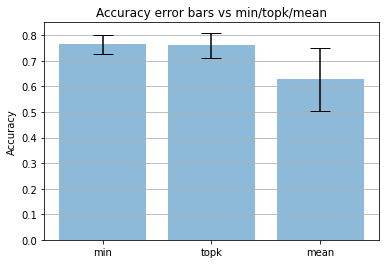

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mean1 = np.mean(min_accuracies)
std1 = np.std(min_accuracies)
mean2 = np.mean(topk_accuracies)
std2 = np.std(topk_accuracies)
mean3 = np.mean(mean_accuracies)
std3 = np.std(mean_accuracies)

mean = [mean1, mean2, mean3]
std = [std1, std2, std3]
labels = ['min', 'topk', 'mean']
x_pos = np.arange(len(labels))

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, 
       mean,
       yerr=std,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Accuracy error bars vs min/topk/mean')
ax.yaxis.grid(True)
